## LSTM model training notebook
### Introduction
IN this notebook, we are going to 
1. build a sine wave generator that is able to generate sine wave with noise, and anomalies
2. train a LSTM model to predict the next timestamp's reading based on the previous readings
3. validate the accuracy of our model
4. save / reload this model

This is a straightforward model that only predict a single dimension sinewave with slight noise. For more complicated production data, you can consider multi-dimensinoal input with more layers and hidden states.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

if torch.cuda.is_available():  
    comput_dev = "cuda:0" 
else:  
    comput_dev = "cpu"
device = torch.device(comput_dev)
print(torch.__version__)

1.6.0


### Data generation: Generate Sine Wave Pattern

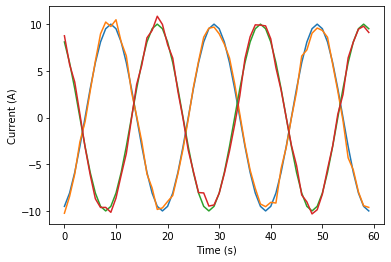

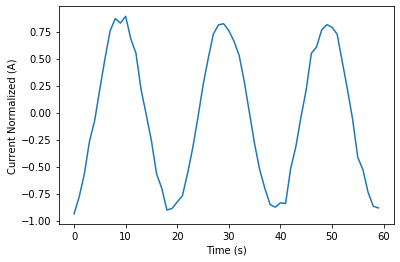

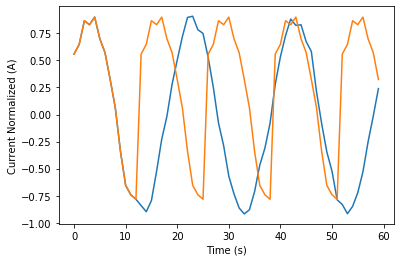

In [16]:
# Sine wave
SR = 20 # number of sample in one period
Visualize_Periods = 3 # number of periods for visualization
seq_lenth = 1000 # sequence length
batch_size = 20 # number of batches
noise = 0.5 # noise level in data

class sine_wave_obj:
    def __init__(self, SR=40):
        self.SR = SR
        self.re_generate()
    def plot(self):
        # Plot
        plt.plot(self.signal[0, :SR*Visualize_Periods])
        plt.plot(self.disturbed_signal[0, :SR*Visualize_Periods])
        plt.plot(self.signal[1, :SR*Visualize_Periods])
        plt.plot(self.disturbed_signal[1, :SR*Visualize_Periods])
        plt.xlabel('Time (s)')
        plt.ylabel('Current (A)')
        plt.show()
        plt.plot(self.final[0, :SR*Visualize_Periods])
        plt.xlabel('Time (s)')
        plt.ylabel('Current Normalized (A)')
        plt.show()
        nor, abn = self.re_generate_abnormal_single()
        plt.plot(nor.cpu()[:SR*Visualize_Periods])
        plt.plot(abn.cpu()[:SR*Visualize_Periods])
        plt.xlabel('Time (s)')
        plt.ylabel('Current Normalized (A)')
        plt.show()
    def re_generate(self):
        self.rand_init = np.random.randint(self.SR, size=batch_size)
        self.t = np.array([range(0, seq_lenth),]*batch_size) + self.rand_init[:, np.newaxis]
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.signal = np.sin(2*np.pi/self.SR*self.t) * 10
        self.disturbed_signal = self.signal + np.random.normal(0, noise, (batch_size, seq_lenth))
        self.final = self.scaler.fit_transform(self.disturbed_signal.T).T
        return torch.FloatTensor(self.final).to(device)
    def re_generate_single(self):
        self.re_generate()
        temp =  self.disturbed_signal[0, :]
        temp_final = self.scaler.fit_transform(temp.reshape(-1, 1))
        return torch.FloatTensor(temp_final.flatten()).to(device)
    def re_generate_abnormal_single(self):
        normal = self.re_generate_single()
        abnormal = normal.clone()
#         # some zero
#         abnormal[20:40] = 0
        # out of phase
        abnormal = abnormal[:13].repeat(100)[:1000]
#         # upward trend
#         abnormal += torch.range(start = 0, end = 9.99, step=0.01).to(device)
        return normal, abnormal
sine_wave = sine_wave_obj(SR)
sine_wave.plot()

### Model Building: Define LSTM model

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, layers = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, self.hidden_layer_size, num_layers=layers).to(device)
        self.linear = nn.Linear(hidden_layer_size, output_size).to(device)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out)
        return predictions

In [10]:
model = LSTM()
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

### Model Training: Generate noisy data and feed into model

In [7]:
epochs = 10
epoch_size = 10
curr_loss = 0
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)
for i in range(epochs):
    for j in range(epoch_size):
        readings = sine_wave.re_generate().transpose(0,1)
        readings_data = readings.view(seq_lenth ,batch_size, 1)[:-1, :, :]
        readings_labels = readings.view(seq_lenth ,batch_size, 1)[1:, :, :]
        def closure():
            global curr_loss
            global optimizer
            optimizer.zero_grad()
            y_pred = model(readings_data)
            single_loss = loss_function(y_pred, readings_labels)
            curr_loss = single_loss
            single_loss.backward()
            return single_loss
        optimizer.step(closure)
        print('curr_loss', curr_loss.item())
    if i%1 == 0:
        msg = f'epoch: {i:3} loss: {curr_loss.item():10.8f}'
        print(msg)
        with open('./training_log.txt', 'a+') as f:
            f.write(msg + '\n')

print(f'epoch: {i:3} loss: {curr_loss.item():10.10f}')


curr_loss 0.00010062013461720198
curr_loss 0.00011637561692623422
curr_loss 0.00011429023288656026
curr_loss 0.00013026408851146698
curr_loss 9.510778181720525e-05
curr_loss 0.00015451940998900682
curr_loss 0.00014223152538761497
curr_loss 0.0001521902740933001
curr_loss 8.569611236453056e-05
curr_loss 0.00012186996173113585
epoch:   0 loss: 0.00012187
curr_loss 8.694118878338486e-05
curr_loss 0.00014480241225101054
curr_loss 0.00014020003436598927
curr_loss 0.00010043764632428065
curr_loss 0.00013858525198884308
curr_loss 0.00011059270036639646
curr_loss 0.00015883099695201963
curr_loss 0.00011916667426703498
curr_loss 0.00010618288797559217
curr_loss 0.00013539142673835158
epoch:   1 loss: 0.00013539
curr_loss 8.946745219873264e-05
curr_loss 0.0001232640352100134
curr_loss 0.00010655319056240842
curr_loss 0.00012718224024865776
curr_loss 0.00011127661855425686
curr_loss 0.00011885399726452306
curr_loss 0.00016183598199859262
curr_loss 0.0001473239972256124
curr_loss 0.000104727725556

### Model Testing:

#### Visualize waveforms with anomaly and withouth anomaly by plotting the noarmalizaed output. 
The first diagram shows sinewave with slight noise and LSTM prediction, but no anomamaly. The second diagram shows sinewave with anomaly and LSTM prediction. The anomaly can be chosen from the waveform generator by commenting out other anomaly options.

torch.Size([1000])
Normal reading loss: 0.005610866006463766
0.005610866006463766
Abnormal reading loss: 0.09801285713911057
(999,)


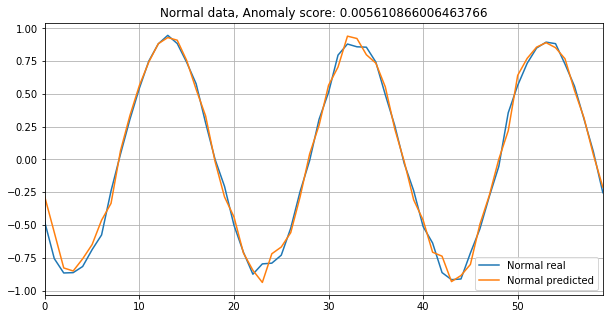

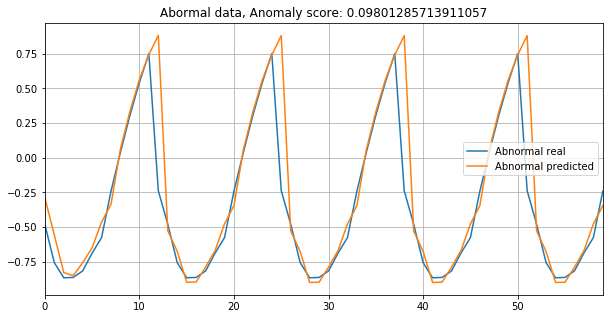

In [17]:
# model.eval()
test_readings, test_abnormal_readings = sine_wave.re_generate_abnormal_single()
print(test_readings.shape)

# normal reading
test_readings_data = test_readings.view(seq_lenth ,1, 1)[:-1, :, :]
test_readings_labels = test_readings.view(seq_lenth ,1, 1)[1:, :, :]
test_pred = model(test_readings_data)
# print(test_pred[0:5], test_readings_labels[0:5])
single_loss = loss_function(test_pred, test_readings_labels)
print('Normal reading loss: {}'.format(single_loss.item()))
print(single_loss.item())
# abnormal reading
test_ab_readings_data = test_abnormal_readings.view(seq_lenth ,1, 1)[:-1, :, :]
test_ab_readings_labels = test_abnormal_readings.view(seq_lenth ,1, 1)[1:, :, :]
test_ab_pred = model(test_ab_readings_data)
single_ab_loss = loss_function(test_ab_pred, test_ab_readings_labels)
print('Abnormal reading loss: {}'.format(single_ab_loss.item()))


y_normal = test_pred.cpu().detach().numpy().flatten()
y_abnormal = test_ab_pred.cpu().detach().numpy().flatten()
print(y_normal.shape)

plt.figure(figsize=(10,5))
plt.grid(True)
plt.title('Normal data, Anomaly score: {}'.format(single_loss.item()))
plt.autoscale(axis='x', tight=True)
normal_real, = plt.plot(test_readings_labels.cpu().view(seq_lenth-1)[:SR*Visualize_Periods], label='Normal real')
normal_pred, = plt.plot(y_normal[:SR*Visualize_Periods], label='Normal predicted')
plt.legend(handles=[normal_real, normal_pred])
plt.show()

plt.figure(figsize=(10,5))
plt.grid(True)
plt.title('Abormal data, Anomaly score: {}'.format(single_ab_loss.item()))
plt.autoscale(axis='x', tight=True)
abnormal_real, = plt.plot(test_ab_readings_labels.cpu().view(seq_lenth-1)[:SR*Visualize_Periods], label='Abnormal real')
abnormal_pred, = plt.plot(y_abnormal[:SR*Visualize_Periods], label='Abnormal predicted')
plt.legend(handles=[abnormal_real, abnormal_pred])
plt.show()


#### Show de-normalized predicted normal and abnormal time series data
Orange line shows abnormal data while blue shows normal data. Both de-normalized.

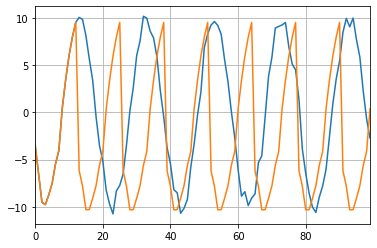

In [18]:
normal_predictions = sine_wave.scaler.inverse_transform(y_normal.reshape(-1, 1)).flatten()
abnormal_predictions = sine_wave.scaler.inverse_transform(y_abnormal.reshape(-1, 1)).flatten()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(normal_predictions.flatten()[0:100])
plt.plot(abnormal_predictions.flatten()[0:100])
plt.show()

#### Plot normal prediction and target together to observe the difference
For normal waveform, show the difference between predicted values and labels. Ideally they should be identical, but since waveform generator also generates some noise, they are not 100 percent identical. 

(999,) (20, 1000)


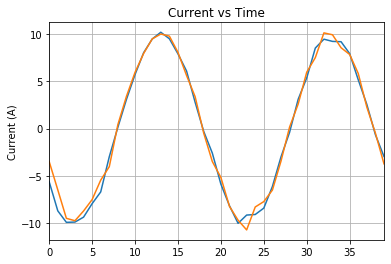

In [19]:
plt.title('Current vs Time')
plt.ylabel('Current (A)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
print(normal_predictions.shape, sine_wave.disturbed_signal[:seq_lenth].shape)
plt.plot(sine_wave.disturbed_signal[0, 1:41])
plt.plot(normal_predictions.flatten()[0:40])
plt.show()


#### Free run this LSTM model with only predicted time series data points
For sanity test, take only several datapoints at the beginning of a sine wave, and then append predicted values as next time series value, and repeat for 700 times. We would like to see if the model automatically generates something that resembles a sinewave.

torch.Size([1000])


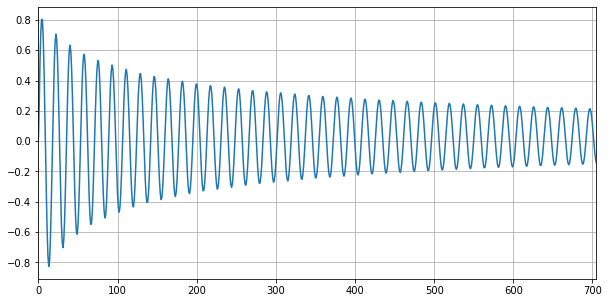

In [20]:
# model.eval()
test_readings, test_abnormal_readings = sine_wave.re_generate_abnormal_single()
print(test_readings.shape)

# normal reading
curr_segment = test_readings[0:6]
for i in range(700):
    curr_segment_processed = curr_segment.view(curr_segment.shape[0] ,1, 1)[i:curr_segment.shape[0], :, :]
    single_pred = model(curr_segment_processed)[-1]
    curr_segment = torch.cat((curr_segment, torch.flatten(single_pred)), 0)
plt.figure(figsize=(10,5))
plt.grid(True)
plt.autoscale(axis='x', tight=True)
normal_real, = plt.plot(curr_segment.cpu().detach().numpy(), label='estimated')
plt.show()

### Save model

In [76]:
torch.save(model.state_dict(), './layer_1_batch50_lr0_01_hs50.pth')

#### Option 1: Load model in GPU

In [11]:
model = LSTM()
with open('model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f, map_location=torch.device('cuda')))
model.to('cuda').state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.1448],
                      [ 0.1378],
                      [-0.1551],
                      [-0.0255],
                      [ 0.1019],
                      [-0.0814],
                      [ 0.0074],
                      [-0.1563],
                      [-0.1446],
                      [ 0.0478],
                      [-0.0181],
                      [ 0.1081],
                      [-0.0141],
                      [-0.0802],
                      [ 0.1208],
                      [ 0.1193],
                      [ 0.0704],
                      [ 0.0727],
                      [-0.0563],
                      [ 0.1054],
                      [-0.0587],
                      [ 0.1481],
                      [ 0.1008],
                      [-0.1109],
                      [ 0.1284],
                      [ 0.0558],
                      [-0.0374],
                      [-0.0288],
                      [-0.1089],
        

#### Option 2: Load model in CPU

In [7]:
model = LSTM()
with open('model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f, map_location=torch.device('cpu')))
model.to('cpu').state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.1448],
                      [ 0.1378],
                      [-0.1551],
                      [-0.0255],
                      [ 0.1019],
                      [-0.0814],
                      [ 0.0074],
                      [-0.1563],
                      [-0.1446],
                      [ 0.0478],
                      [-0.0181],
                      [ 0.1081],
                      [-0.0141],
                      [-0.0802],
                      [ 0.1208],
                      [ 0.1193],
                      [ 0.0704],
                      [ 0.0727],
                      [-0.0563],
                      [ 0.1054],
                      [-0.0587],
                      [ 0.1481],
                      [ 0.1008],
                      [-0.1109],
                      [ 0.1284],
                      [ 0.0558],
                      [-0.0374],
                      [-0.0288],
                      [-0.1089],
        